In [1]:
%run "catalog_common.py" 
ID_header('Open-FF: New Disclosures Report', incl_links=False)

,"Open-FF: New Disclosures Report Data repository: v12_BETA_2022-02-19; This file generated: February 20, 2022."


In [2]:
import pandas as pd
import numpy as np
import os
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show as iShow
import itables.options as opt

# def iShow(df,maxBytes=0):
#     display(df)

df = ana_set.Catalog_set(repo = repo_name, outdir='../common/').get_set(verbose=False)
gb2 = df.groupby('bgCAS')['IngredientName'].agg(lambda x: x.value_counts().index[0])
gb2 = gb2.reset_index()
gb2.columns = ['bgCAS','comm_name']
df = pd.merge(df,gb2,on='bgCAS',how='left')

df['perc_rank'] = df.groupby('bgCAS')['calcMass'].rank(pct=True)*100

<IPython.core.display.Javascript object>

In [3]:
#preamble to analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import matplotlib.ticker

from time import sleep
from datetime import datetime, timedelta
now = datetime.now()
one_year_ago = now-timedelta(days=365)
today = str(datetime.today())
today = today.split()[0]
todaytxt = datetime.today().strftime("%B %d, %Y")


In [4]:
updates= grd.get_curated_df(repo=repo_name,df_fn='upload_dates.csv')
updates['dt_added'] = pd.to_datetime(updates.date_added)
updates.weekly_report = pd.to_datetime(updates.weekly_report)
updates['days_old'] = (now - updates.dt_added).dt.days

# Instead of using days old, use the field weekly_report to find un-reported disclosures
week_upk = updates[updates.weekly_report.isna()].UploadKey.tolist()
last_report = str(updates[~updates.weekly_report.isna()].weekly_report.max()).split()[0] 

last_report_dt = pd.to_datetime(last_report)
last_report = last_report_dt.strftime("%B %d, %Y")

In [5]:
display(md(f"""## FracFocus disclosures published between {last_report} and {bulkdata_date}"""))

## FracFocus disclosures published between February 06, 2022 and February 19, 2022

This report summarizes the fracking jobs published this week at [FracFocus](https://fracfocus.org/), the industry-funded chemical disclosure instrument. It includes the Who, What and Where of recent fracking activity: the operating companies, the chemicals they use (including quantities), and where these jobs are located.

This report is produced by [Open-FF](https://frackingchemicaldisclosure.wordpress.com/), an open source, public service project to make the FracFocus data more usable. The nature of the fracking chemical data is complicated and can be difficult to make sense of; Open-FF aims to make it those data more digestible. In addition, FracFocus disclosures are plagued by inconsistencies, ambiguous and missing values and many obvious data errors; Open-FF flags and filters many of those problems. Our hope is that these reports give readers both big-picture perspectives of industry activities as well as enough detail to dig deeply into specifics such as individual chemicals, fracking job, or company.

   
## In this report:

### Overview of all FracFocus disclosures published this period by
- [State](#state), [County](#county), [Operators](#operators), [Land type](#fed) 
- [Water use](#water)
- [Recognized Chemicals of Concern](#chems)
- [Proprietary claims](#proprietary) 

### [Detailed list](#detailed) of all disclosures including:
- Location, company name, API number, water use, chemicals of concern, and Federal/Indian well indicator
- Link to satellite image and Google map of fracking site

#### [Disclosures with masses of Chemicals of Concern](#bigcomp) in the top 10% of FracFocus

### [Silent changes detected](#silent)

### [Fracking frequency](#pubfreq)
    

# Overview

In [6]:
display(md(f'### Since {last_report}, the number of new disclosures added to FracFocus is: '))
display(md(f'> # {len(week_upk)}'))

### Since February 06, 2022, the number of new disclosures added to FracFocus is: 

> # 479

In [7]:
weekdf = df[df.UploadKey.isin(week_upk)].copy()
if len(weekdf)>0:
    weekdf['map_link'] = weekdf.apply(lambda x: getLink(x),axis=1)
    weekdf['apiMap'] = weekdf.apply(lambda x: getAPIMapLink(x),axis=1)
else:
    weekdf['map_link'] = ''
    weekdf['apiMap'] = weekdf.APINumber

In [8]:
display(md(f'### Where these {len(week_upk)} fracking jobs occurred:'))

### Where these 479 fracking jobs occurred:

<a id='state'></a>
###   ...  by state

In [9]:
gb = weekdf.groupby(['StateName','CountyName','UploadKey'],as_index=False)['CASNumber'].count().drop('CASNumber',axis=1)
#len(gb)

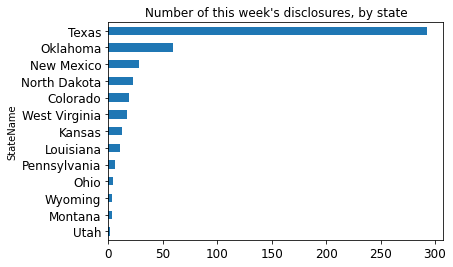

In [10]:
#print(gb.head())
gb.groupby(['StateName'])['UploadKey'].count().sort_values().plot.barh(ylabel='',#figsize=(10,6),
                                                             title="Number of this week's disclosures, by state",
                                                             fontsize=12);

<a id='county'></a>
###   ...  by county

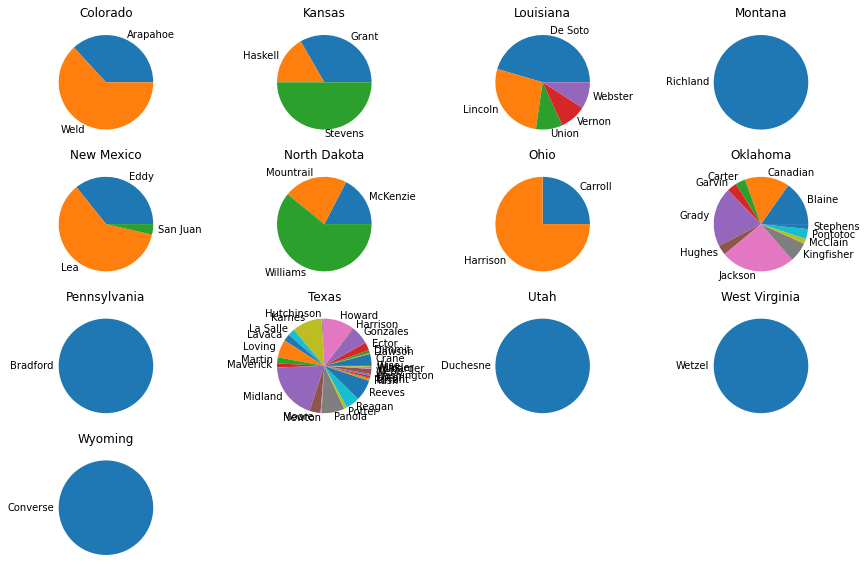

In [11]:
from math import ceil
sts = gb.StateName.unique().tolist()
sts.sort()
if len(sts)>4:
    griddim = (ceil(len(sts)/4),4)
    emp = griddim[0]*griddim[1] - len(sts)

    fig, axes = plt.subplots(ceil(len(sts)/4), 4, figsize=(15, 10))
    for i,st in enumerate(sts):
        ax = axes[i // 4, i % 4]
        gb[gb.StateName==st].groupby(['CountyName'])['UploadKey'].count().plot.pie(ylabel='',fontsize=10,
                                                                      ax = ax, title=st)
    if emp>0:
        for i in range(emp):
            fig.delaxes(axes.flatten()[-(i+1)])    
else:
    fig,axes = plt.subplots(1,len(sts),figsize=(10,10))
    for i,st in enumerate(sts):
        ax = axes[i]
        gb[gb.StateName==st].groupby(['CountyName'])['UploadKey'].count().plot.pie(ylabel='',fontsize=10,
                                                                      ax = ax, title=st)


<a id='operators'></a>
### ...  by top Operators

In [1]:
gb = weekdf.groupby(['OperatorName','UploadKey'],as_index=False)['CASNumber'].count()
gb.groupby(['OperatorName'])['UploadKey'].count().sort_values()[-15:].plot.barh(figsize=(6,6),
                                                                                    title='number of disclosures');

NameError: name 'weekdf' is not defined

### Operator list for all disclosures

In [13]:
#gbs = weekdf.groupby(['OperatorName','UploadKey'],as_index=False)['StateName'].count()
gb2 = weekdf.groupby(['OperatorName'])['StateName'].apply(set)
gb1 = gb.groupby(['OperatorName'],as_index=False)['UploadKey'].count()\
        .sort_values(['UploadKey','OperatorName'],ascending=False)
gb1 = pd.merge(gb1,gb2,on='OperatorName',how='left')
gb1.StateName = gb1.StateName.map(lambda x: xlate_to_str(x, sep= ', '))
gb1.columns = ['Operator','Num disclosures','in States']
iShow(gb1.reset_index(drop=True),columnDefs=[{'width':'100px', 'targets':"_all"}])

Operator,Num disclosures,in States


<a id='fed'></a>
### ... "Federal wells" or "Indian wells"

In [ ]:
gb = weekdf[weekdf.FederalWell=='True'].groupby(['OperatorName','UploadKey'],as_index=False)['CASNumber'].count()
if len(gb)>0:
    gb = gb.groupby(['OperatorName'])['UploadKey'].count().sort_values().plot.barh(figsize=(10,len(gb.OperatorName.unique())*0.5),
                                                                                    title='Federal Lands: number of disclosures')
else:
    display(md('#### >>>> No "federal wells" reported'))

In [ ]:
gb = weekdf[weekdf.IndianWell=='True'].groupby(['OperatorName','UploadKey'],as_index=False)['CASNumber'].count()
if len(gb)>0:
    
    gb = gb.groupby(['OperatorName'])['UploadKey'].count().sort_values().plot.barh(figsize=(10,len(gb.OperatorName.unique())*0.5),
                                                                                    title='"Indian Wells:" number of disclosures')
else:
    display(md('#### >>>>  No "indian wells" reported'))
    


---
<a id='water'></a>
## Water use for this report's disclosures

Thick vertical lines in the graph indicate 25, 50 and 75% percentiles for this report's disclosures.

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
wdf = weekdf.groupby('UploadKey',as_index=False)[['TotalBaseWaterVolume','StateName']].first()
sn = wdf.groupby('StateName',as_index=False)['UploadKey'].count().astype('str')
sn.columns = ['StateName', 'cnt']
wdf = pd.merge(wdf,sn,on='StateName',how='left')
wdf['State_Num'] = wdf.StateName+'__'+wdf.cnt
wdf = wdf.sort_values('cnt',ascending=False)
fig = plt.figure(figsize=(15,8))
ax = sns.stripplot(x=wdf.TotalBaseWaterVolume,y=wdf.State_Num,jitter=.2,alpha=.4,size=10)
plt.xlabel(f'water volume (gallons):',fontsize=14);
plt.title(f'Water Use for events published in the week before {todaytxt}',fontsize=16)
ax.set(xscale='log')
ax.set(xlim=(max(10000,wdf.TotalBaseWaterVolume.min()),wdf.TotalBaseWaterVolume.max()*1.2))
ax.grid(axis='y')
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
locmaj = matplotlib.ticker.LogLocator(base=10,subs='all') 
ax.xaxis.set_major_locator(locmaj)

lns = list(np.percentile(wdf[wdf.TotalBaseWaterVolume>0].TotalBaseWaterVolume,[25,50,75]))
ax.set_ylim(-0.7,len(sn)-0.3)
for l in lns:
    plt.vlines(l,-0.7,len(sn),color='black')
totgal = wdf.TotalBaseWaterVolume.sum()

s = f' -- number of empty TBWV: {(~(wdf.TotalBaseWaterVolume>0)).sum()}\n'
s+= ' -- 25%:  {:,} gallons\n'.format(int(lns[0]))
s+= ' -- 50%:  {:,} gallons\n'.format(int(lns[1]))
s+= ' -- 75%:  {:,} gallons\n'.format(int(lns[2]))
s+= ' -- max:  {:,} gallons\n'.format(int(wdf.TotalBaseWaterVolume.max()))
s+= ' -- TOTAL {:,} gallons\n'.format(int(totgal))
print(s)


<a id='chems'></a>
## Recognized Chemicals of Concern used in these disclosures
The following table is based on lists of chemicals that have health or environmental effects: SDWA, CWA, Proposition 65, PFAS and TEDX. 

In [ ]:
# new chemicals of concern table
weekdf['on_list'] = np.where(weekdf.is_on_CWA,'CWA; ','')
weekdf.on_list = np.where(weekdf.is_on_DWSHA,weekdf.on_list+'DWSHA; ',weekdf.on_list)
weekdf.on_list = np.where(weekdf.is_on_TEDX,weekdf.on_list+'TEDX; ',weekdf.on_list)
weekdf.on_list = np.where(weekdf.is_on_prop65,weekdf.on_list+'prop65; ',weekdf.on_list)
weekdf.on_list = np.where(weekdf.is_on_PFAS_list,weekdf.on_list+'PFAS; ',weekdf.on_list)
weekdf.on_list = np.where(weekdf.is_on_volatile_list,weekdf.on_list+'Volatile; ',weekdf.on_list)

chemconcern = weekdf[~(weekdf.on_list=='')].groupby('bgCAS',as_index=False)[['comm_name']].first()\
                     .rename({'comm_name':'Chemical Name'},axis=1)
gb1 =  weekdf[~(weekdf.on_list=='')].groupby('bgCAS',as_index=False)[['IngredientName']].count().rename({'IngredientName':'record count'},
                                                                                                       axis=1)
gb2 = weekdf[~(weekdf.on_list=='')].groupby('bgCAS',as_index=False)[['on_list']].first()
gb3 = weekdf[~(weekdf.on_list=='')].groupby('bgCAS',as_index=False)[['calcMass']].max().rename({'calcMass':'Largest Mass'},
                                                                                               axis=1)
gb4 = weekdf[~(weekdf.on_list=='')].groupby('bgCAS',as_index=False)[['perc_rank']].max().rename({'perc_rank':'% Rank of Largest Mass'},
                                                                                               axis=1)

chemconcern = pd.merge(chemconcern,gb1,on='bgCAS',how='left')
chemconcern = pd.merge(chemconcern,gb2,on='bgCAS',how='left')
chemconcern = pd.merge(chemconcern,gb3,on='bgCAS',how='left')
chemconcern = pd.merge(chemconcern,gb4,on='bgCAS',how='left')
l=[]
for i in range(len(chemconcern)):
    l.append('c'+str(i+1).zfill(2))
chemconcern['CID'] = pd.Series(l)
chemconcern['CAS Number'] = chemconcern.bgCAS.map(lambda x: getCatLink(x,x,use_remote=True))
print(f'Total number of records on Chemical of Concern list for these disclosures: {chemconcern["record count"].sum()}')
iShow(chemconcern[['CID','CAS Number','Chemical Name','record count',
                   'Largest Mass','% Rank of Largest Mass',
                   'on_list']].reset_index(drop=True),
      index=False)

|Explanation of columns in the index above|
| :---: |


| Column      | Description |
| :----: | :-------- |
|*CID*| is the chemical ID used in the disclosure table | 
|*CAS Number*| is the CAS registration number of the chemical. Click on the number for a summary of this chemical for all of FracFocus.|  
|*Chemical Name*| is one of the common names for the material|
|*record count* |indicates the number of records in this week's disclosures. A given chemical may appear more than once in a disclosure|
|*Largest mass*| is the single greatest mass of the chemical in this week's disclosures (in pounds)|
|*% Rank of largest Mass*|how the largest mass from this week compares to the rest of FracFocus data (through last update). Ex. 95.0 means that this mass was in the top 5% of all uses ever recorded in FracFocus. If there are records with values of 90% or more, a list of all disclosures are in a [table](#bigcomp) later in this report. 
|*on_list*|indicates which of the following lists the chemical is on.  Type the name of the list into the Search box to limit to those chemicals.<br> - **CWA**: indicates that the chemical is on the [Clean Water Act list](https://comptox.epa.gov/dashboard/chemical_lists/CWA311HS) as compiled in EPA's CompTox<br>- **DWSHA**: indicated that the chemical is on the EPA's [Drinking Water Safety and Health Advisory](https://comptox.epa.gov/dashboard/chemical_lists/EPADWS) list<br>- **TEDX**: indicates that the chemical is on [The Endocrine Disruption Exchange](https://endocrinedisruption.org) list<br>- **prop_65**: indicates that the chemical is on [California's Proposition 65](https://oehha.ca.gov/proposition-65/proposition-65-list) list<br>- **PFAS**: indicates that the chemical is on EPA's comprehensive list of PFAS related compounds<br>- **Volatile**: indicates that the chemical is on the EPA's volatile chemical list|



In [ ]:
weekdf['proprietary'] = weekdf.bgCAS=='proprietary'
gb1 = weekdf.groupby('UploadKey',as_index=False)['PercentHFJob'].sum()
gb1['in_perc_tolerance'] = (gb1.PercentHFJob<110)&(gb1.PercentHFJob>90)

gb2 = weekdf[weekdf.proprietary].groupby('UploadKey',as_index=False)['calcMass'].sum()
gb2 = gb2.rename({'calcMass':'prop_mass'},axis=1)

gb = weekdf.groupby(['UploadKey'],as_index=False)[['CountyName','StateName',
                                                    'OperatorName','APINumber',
                                                    'TotalBaseWaterVolume','TVD',
                                                    'FederalWell','IndianWell',
                                                    'map_link','date','apiMap']].first()
gb = pd.merge(gb,gb1[['UploadKey','PercentHFJob']],on='UploadKey',how='left')
gb = pd.merge(gb,gb2,on='UploadKey',how='left')


In [ ]:
weekdf = pd.merge(weekdf,chemconcern[['bgCAS','CID']],on='bgCAS',how='left')

In [ ]:
def sort_id(st):
    l = list(st)
    l.sort()
    return l
weekchem = weekdf[weekdf.bgCAS.isin(chemconcern.bgCAS.tolist())].groupby(['UploadKey'])['CID'].apply(set).reset_index()
weekchem.CID = weekchem.CID.map(lambda x: sort_id(x))
weekdf = weekdf.drop('CID',axis=1)
disc = pd.merge(gb,weekchem,on='UploadKey',how='left')

<a id='proprietary'></a>
# Proprietary labeling 
FracFocus allows disclosures to hide the identity of chemicals that companies claim are business secrets.  This practice has been controversial since the beginning of FracFocus.  Some changes in format (the 'system approach') were made to purportedly reduce the use of proprietary claims.  Nevertheless, they are still commonly employed.  The following summarizes how much the past week's disclosures hid chemical identity with these claims. A detailed disclosure listing later in this report specifies the percentage of chemical records that are hidden by these claims for every disclosure.  They range from zero percent to 70% or even more.   

As of version 10, Open-FF detects proprietary claims by both the CASNumber and IngredientName fields.  


In [ ]:
numprop = weekdf.proprietary.sum()
display(md(f'## Total number of proprietary claims since {last_report}: {numprop:,} records'))
display(md('---'))

In [ ]:
# proprietary summaries
weekdf['clean_cas'] = (weekdf.is_valid_cas)&~(weekdf.bgCAS=='proprietary')
pgb = weekdf.groupby('UploadKey',as_index=False)[['proprietary','clean_cas']].sum()
pgb['fraction_prop'] = pgb.proprietary/(pgb.clean_cas+pgb.proprietary)
pgb['percent_proprietary'] = (pgb.fraction_prop)*100
#print(pgb.percent_proprietary)
ax = pgb.percent_proprietary.hist()
ax.set_ylabel('Number of disclosures')
ax.set_xlabel('Percent of records that are proprietary')
ax.set_title('Percent of disclosure records that are claimed as "proprietary"',fontsize=15);

## Portion of records hidden, by state

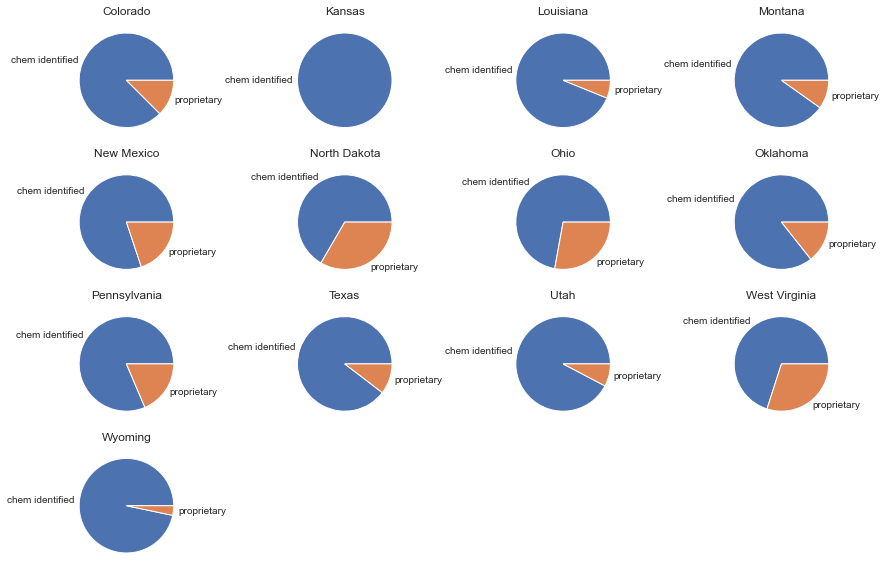

In [23]:
# proprietary summaries by state
sts = weekdf.StateName.unique().tolist()
sts.sort()
weekdf['cas_stat'] = np.where(weekdf.proprietary,'proprietary','other')
weekdf['cas_stat'] = np.where(weekdf.clean_cas,'chem identified',weekdf.cas_stat)
if len(sts)>4:
    griddim = (ceil(len(sts)/4),4)
    emp = griddim[0]*griddim[1] - len(sts)

    fig, axes = plt.subplots(ceil(len(sts)/4), 4, figsize=(15, 10))
    for i,st in enumerate(sts):
        ax = axes[i // 4, i % 4]
        cond = (weekdf.StateName==st)&(~(weekdf.cas_stat=='other'))
        weekdf[cond].groupby(['cas_stat'])['UploadKey'].count().plot.pie(ylabel='',fontsize=10,
                                                                      ax = ax, title=st)
    if emp>0:
        for i in range(emp):
            fig.delaxes(axes.flatten()[-(i+1)])    
else:
    fig,axes = plt.subplots(1,len(sts),figsize=(10,10))
    for i,st in enumerate(sts):
        ax = axes[i]
        cond = (weekdf.StateName==st)&(~(weekdf.cas_stat=='other'))
        weekdf[cond].groupby(['cas_stat'])['UploadKey'].count().plot.pie(ylabel='',fontsize=10,
                                                                      ax = ax, title=st)


<a id='proprietary_names'></a>
## Ingredient names used for proprietary records for this report's disclosures
Because these are proprietary claims, the reported ingredient name will not be specific, usually just a general class.

In some cases, companies do not report the PercentHFJob or report 0.0% for proprietary records. We use 0.0 pounds for those records in the following table.

In [24]:
weekdf['ing'] = weekdf.IngredientName.str.strip().str.lower()
tmp = pd.DataFrame(weekdf[weekdf.proprietary].value_counts('ing'))
promass = weekdf[weekdf.proprietary].groupby('ing',as_index=False)['calcMass'].sum()
promass.calcMass = promass.calcMass.astype('int')
tmp = pd.merge(tmp,promass,on='ing',how='left')
tmp = tmp.reset_index(drop=True)
propops = weekdf[weekdf.proprietary].groupby('ing')['bgOperatorName'].apply(set)
tmp = pd.merge(tmp,propops,on='ing',how='left')
tmp.bgOperatorName = tmp.bgOperatorName.map(lambda x: xlate_to_str(x,'; ',trunc=True,tlen=20))
tmp = tmp.sort_values([0,'calcMass'],ascending=False)
tmp.columns=['Reported Ingredient Name','Num of records','total proprietary mass (pounds)','Operators using this label']
#tmp.style.hide_index().format({'total proprietary mass (pounds)':"{:,}"})
tmp = tmp.reset_index(drop=True)

opt.classes = ['display','compact']
opt.columnDefs=[{"width": "1200px", "targets": "Num of records"}]
iShow(tmp,maxBytes=0)

Reported Ingredient Name,Num of records,total proprietary mass (pounds),Operators using this label


---
# Detailed disclosure listings

### Notes:

**Listing of chemicals in individual disclosures:**  In the table below, individual fracking disclosures are identified by APINumber.  If you are interested in seeing the details of the raw data, use that APINumber at the FracFocus ["Find a Well" site](http://fracfocusdata.org/DisclosureSearch/Search.aspx).  That search site will serve pdf files of individual fracking events to your computer with most of the same raw data available used here. However,  mass of chemicals is not available from these pdfs.

**Maps:**  In the table below, a link is provided to a Google map/satellite view of the location provided in the disclosure (click on the APINumber).   Many recently published fracking sites are **newer** than the satellite image that Google uses, so the well pad may not be visible.  However, you can still view the geographic context of the drilling site.

<a id='detailed'></a>
## Listing of all new disclosures published since last report

|Columns descriptions and issues to look for |
| :--- |

- **FID** - Fracking job ID number (used in following table to identify heavy use of chemical)
- **Water volume** - volume in gallons of the water base fluid used in a fracking job
  - Especially large fracking carrier (>30 million gallons)
  - No data or a report of ZERO gallons of water. This prevents the calculation of chemical mass
- **TVD** - True vertical depth (feet)
  - No data or a report of ZERO feet.
  - Deeper than deepest oil well (35,050 ft.): likely error
- **Percent proprietary** - proportion of chemical records for which identity is hidden
  - 25% or greater
- **End date** - Last day of job
  - many states require disclosure within 30 or 90 days. 
  - sometimes end date is in the future, indicating mis-representation
- **Total percentage ("perc sum")** - the sum of all records in a disclosure should be 100% (within a tolerance)
  - if less than 90%, disclosure is probably incomplete
  - greater than 110% - often caused by a "system approach"  entry error: duplicates of some chemical records or hidden percentages in the tradename/purpose/supplier section. 
- **CIDs in disclosure** - see the Chemicals of Concern table above for more information
- **APINumber** - click on this link to see a Google map of the location of this well

In [25]:
#gb['Water_vol_gallons'] = gb.TotalBaseWaterVolume.map(lambda x: round_sig(x,3))
disc['Type_well'] = np.where(disc.FederalWell=='True','Federal\n','')
disc.Type_well= np.where(disc.IndianWell=='True','Indian',disc.Type_well)
# gb = gb.drop(['TotalBaseWaterVolume','FederalWell','IndianWell'],axis=1)
gbn = disc.drop(['FederalWell','IndianWell'],axis=1)
gbn['datestr'] = gbn.date.apply(lambda x: x.strftime('%Y-%m-%d'))
gbn = pd.merge(gbn,pgb[['UploadKey','fraction_prop']],on='UploadKey',how='left')
gbn = gbn.sort_values(['StateName','CountyName','OperatorName']).reset_index()
l=[]
for i in range(len(gbn)):
    #print(i,row.StateName,row.CountyName)
    l.append('F'+str(i+1).zfill(3))
gbn['FID'] = pd.Series(l)
if len(gbn)>0:
    t = gbn[['FID','StateName','CountyName','OperatorName','apiMap','datestr',
            'TotalBaseWaterVolume','TVD','PercentHFJob',
            'Type_well','fraction_prop','CID']].copy()
    t.CID = t.CID.map(lambda x: xlate_to_str(x))
    #t.APINumber = t.APINumber.map(lambda x: make_anchor(x))
    t.TotalBaseWaterVolume.fillna(0,inplace=True)
    t.TotalBaseWaterVolume = t.TotalBaseWaterVolume.astype('int')
    t.TVD = t.TVD.astype('int')
    t.PercentHFJob= t.PercentHFJob.astype('int')

    t = t.rename({'StateName':'State',
                  'CountyName':'County',
                  'OperatorName':'Operator',
                  #'APINumber':'API Number',
                  'apiMap':'API Number',
                  'datestr':'end date',
                  'pub_delay':'pub delay days',
                  'TotalBaseWaterVolume':'Water volume (gal)',
                  'TVD':'TVD (feet)',
                  'PercentHFJob':'perc sum',
                  #'map_link':'link',
                  'Type_well':'Type Land',
                  'fraction_prop':'fraction proprietary',
                  'CID':'CIDs in disclosure'},
                  #'prop_mass':'proprietary mass pounds'},
                  axis=1)
    iShow(t,maxBytes=0)

FID,State,County,Operator,API Number,end date,Water volume (gal),TVD (feet),perc sum,Type Land,fraction proprietary,CIDs in disclosure


In [26]:
have_big_concerns = False
if chemconcern['% Rank of Largest Mass'].max() > 90:
    have_big_concerns = True
    ccbgcas = chemconcern.bgCAS.unique().tolist()
    bigcomp = weekdf[weekdf.bgCAS.isin(ccbgcas)].copy()
    bigcomp = bigcomp[bigcomp['perc_rank']>90]
    bigcomp = bigcomp[['APINumber','bgCAS','comm_name','calcMass','perc_rank','bgOperatorName','apiMap']]


<a id='bigcomp'></a>
## Disclosures with chemicals-of-concern masses in the top 10% of all FracFocus

In [27]:
if have_big_concerns:
    #display(md('## Disclosures with chemicals-of-concern masses in the top 10% of all FracFocus'))
    display(md('A disclosure may have more than one chemical record in the top 10% for a given CASNumber. This could be due to more than one Trade-named product using that chemical.'))
    mg = pd.merge(bigcomp,gbn[['FID','APINumber','OperatorName']],on='APINumber',how='left')
    bigc = mg.reset_index(drop=True)

    bigc.columns = ['APINumber_raw','CAS Number','Name','Mass of chemical','Percent ranking in FracFocus','bgOperatorName','API Number','FID','Operator']
    iShow(bigc[['FID','API Number','Operator','CAS Number','Name','Mass of chemical','Percent ranking in FracFocus']])
else:
    display(md('## No disclosures with chemicals-of-concern masses in the top 10% of FracFocus'))

A disclosure may have more than one chemical record in the top 10% for a given CASNumber. This could be due to more than one Trade-named product using that chemical.

FID,API Number,Operator,CAS Number,Name,Mass of chemical,Percent ranking in FracFocus


---
<a id='silent'></a>
# "Silent" changes detected

FracFocus allows companies to change disclosures *after* they have been published.  That includes changing individual data records in disclosures and even completely removing a disclosure.  What these changes are and why they are made is not recorded, at least for public access.

Open-FF tries to detect such changes by comparing ALL current disclosures to an archive from the last download.  The table below summarizes the changes detected since the last new-data was posted.  Note that Open-FF currently checks only the major fields in the bulk download file for changes, not every byte.




In [28]:
def get_orig_date(s):
    try:
        l = s.split(' ')
        return pd.to_datetime(l[0])
    except:
        return s
def get_num_fields(s):
    if s:
        return str(s.count(';'))
    return '?'

silent = pd.read_csv(transformed_loc+'tripwire_summary.csv',quotechar='$',encoding='utf-8',
                    dtype={'APINumber':'str'})
silent['detected'] = pd.to_datetime(silent.new_date)
silent['job_end_date'] = silent.orig_date.map(lambda x: get_orig_date(x))
silent.fields_changed.fillna('dropped',inplace=True)
silent['num_fields_changed'] = silent.fields_changed.map(lambda x: get_num_fields(x))
silent = silent[silent.detected>last_report_dt]
iShow(silent[['APINumber','OperatorName','job_end_date','type_of_diff',
              'num_fields_changed','detected','UploadKey']].reset_index(drop=True),maxBytes=0)


APINumber,OperatorName,job_end_date,type_of_diff,num_fields_changed,detected,UploadKey


---
<a id='pubfreq'></a>
# Fracking frequency across time
Number of disclosures per week by the end date of the job.   

In [29]:
# updates['added'] = updates.dt_added.apply( lambda updates : datetime(year=updates.year, month=updates.month, day=updates.day))
# updates.set_index(updates["added"],inplace=True)
# updates.drop('added',axis=1,inplace=True)
# counts = updates.resample('M').count()
# counts.reset_index(inplace=True)
# pmax = counts[counts.added.dt.year>2018].UploadKey.max()*1.05
# ax = counts[counts.added.dt.year>2018].plot('added','UploadKey',ylim=(0,pmax),
#                                       figsize=(12,5));
# ax.set_title('Number of new disclosures published per month',fontsize=18);
# plt.xticks(fontsize=15);
# plt.xlabel('date',fontsize=15)
# plt.yticks(fontsize=15);
# plt.grid(True)


In [30]:
# # Postpone until I work out the "january" glitch

# pdf_df = pd.read_csv(os.path.join(transformed_loc,'PDF_fn_info.csv'),quotechar='$',encoding='utf-8')
# pdf_df['timestamp'] = pd.to_datetime(pdf_df.parse_date,errors='coerce')
# pdf_df = pdf_df[pdf_df.timestamp.dt.year>2010]
# pdf_df = pdf_df[pdf_df.timestamp.notna()]
# print(f'PDFs are collected by OpenFF only periodically. The most recent timestamp is: {pdf_df.timestamp.max()}\n\n')
# # pdf_df['Year/Week'] = pdf_df['timestamp'].apply(lambda x: "%d/%s" % (x.year,str(x.week).zfill(2)))
# # gb = pdf_df.groupby(['Year/Week'],as_index=False).size()
# # gb['wk'] = gb['Year/Week'].str[-2:] 
# # gb['yr'] = gb['Year/Week'].str[:4]
# # gb['lab'] = np.where(gb.wk=='01',gb.yr,'')
# # gb.plot.bar('Year/Week','size',xlabel=gb.lab);
# gb = pdf_df.groupby('timestamp').size()
# wk_sum = gb.resample("W").sum()
# wk_sum.plot(figsize=(12,5),title='Number of disclosures published by FracFocus weekly', ylabel='Number of disclosures');



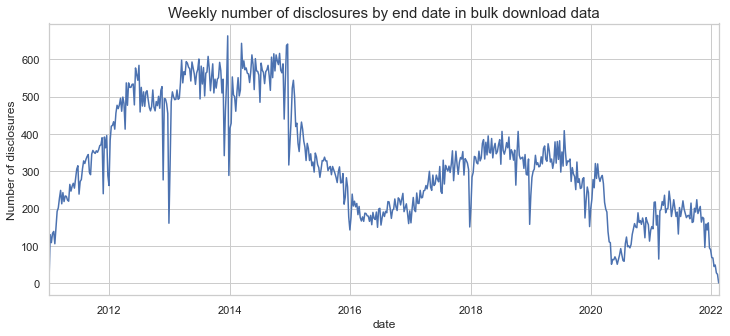

In [31]:

alldf = df[df.data_source=='bulk'].groupby('UploadKey',as_index=False)['date'].first()
#alldf = df.groupby('UploadKey',as_index=False)['date'].first()
alldf = alldf[(alldf.date.dt.year>2010)&(alldf.date.dt.year<=datetime.now().year)]
gb = alldf.groupby('date').size()
allwk_sum = gb.resample("W").sum()

#ax = wk_sum.plot(figsize=(12,5),title='Number of disclosures published by FracFocus weekly', ylabel='Number of disclosures');

ax = allwk_sum.plot(figsize=(12,5), ylabel='Number of disclosures');
ax.set_title('Weekly number of disclosures by end date in bulk download data',fontsize=15);


In [32]:
set_page_param()